<a href="https://colab.research.google.com/github/Dicere/WB_Internship/blob/main/0_6_Generate_feature_f1_f8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost
!pip install lazypredict
!pip install featuretools
!pip install Boruta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.0/618.0 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 24.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.2 MB/s eta 0:00:00


In [2]:
from google.colab import output
output.enable_custom_widget_manager()

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from catboost import CatBoostClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, classification_report, recall_score, precision_recall_curve,precision_score, precision_recall_fscore_support
import statsmodels.api as sm
from sklearn.model_selection import StratifiedKFold
from lazypredict.Supervised import LazyClassifier
import matplotlib.pyplot as plt
from boruta import BorutaPy

In [4]:
df = pd.read_csv('/content/drive/MyDrive/WB_стажировка/wb_school_task_2.csv.gzip',compression='gzip')
df = df.drop_duplicates(ignore_index=True)

In [5]:
kvad_sum=(lambda x: sum(i**2 for i in x))
kvad_sum.__name__ = 'kvad_sum'

interkvartil_razmah = (lambda x: np.percentile(x, 75) - np.percentile(x, 25))
interkvartil_razmah.__name__ = 'interkvartil_razmah'

range_dannih = (lambda x: x.max()-x.min())
range_dannih.__name__ = 'range_dannih'

quant90 = lambda x: x.quantile(0.9)
quant90.__name__ = 'quant90'

In [6]:
aggs_list = ['min','max', 'mean', 'median', 'count', 'sum',kvad_sum,interkvartil_razmah,range_dannih,quant90]

In [7]:
df_agg = df[['id3','f1','f2','f3','f4','f5','f6','f7','f8']].groupby(by=['id3']).agg(aggs_list).reset_index()
df_agg.columns = ['_by_id3_'.join(col) for col in df_agg.columns.values]
df_agg = df_agg.rename(columns={'id3_by_id3_':'id3'})

In [8]:
df1 = pd.merge(df,df_agg,how='left',on=['id3'])

In [9]:
# df1[df1.filter(regex='_sum').columns].columns

In [10]:
# df = df.rename(columns={"f1": "number_reviews_by_user", "f3": "mean_rating_user","f4": "number_reviews_by_item","f5":"number_photos","f6": "mean_rating_item","f7": "number_purchased","f8": "number_orders"})

In [11]:
clear_df = df1[['f1','f2','f3','f4','f5','f6','f7','f8','f1_by_id3_sum', 'f2_by_id3_sum', 'f3_by_id3_sum', 'f4_by_id3_sum',
       'f5_by_id3_sum', 'f6_by_id3_sum', 'f7_by_id3_sum', 'f8_by_id3_sum']]

In [12]:
feature_dict = {}
def summ(b=0,i=0):
  name = str('sum_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
  feature_dict[name] = clear_df.iloc[:,b] + clear_df.iloc[:,i]
def subtraction(b=0,i=0):
    name = str('subtraction_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
    feature_dict[name] = abs(clear_df.iloc[:,b] - clear_df.iloc[:,i])
def multiplication(b=0,i=0):
    name = str('multiplication_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
    feature_dict[name] = abs(clear_df.iloc[:,b] * clear_df.iloc[:,i])
def division(b=0,i=0):
    name = str('division_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
    feature_dict[name] = abs((clear_df.iloc[:,b] / clear_df.iloc[:,i]).fillna(0))
    name = str('division_'+clear_df.columns[i]+"_"+clear_df.columns[b])
    feature_dict[name] = abs((clear_df.iloc[:,i] /clear_df.iloc[:,b]).fillna(0))

In [13]:
conversions_list = {'sum':summ,'subtraction':subtraction,'division':division,'multiplication':multiplication}

In [14]:
idx=0
for conv in conversions_list.keys():
  for b in range(len(clear_df.columns)-1):
    if conv == 'multiplication':
      for i in range(b,len(clear_df.columns)):
        conversions_list[conv](b,i)
    else:
      for i in range(b+1,len(clear_df.columns)):
        conversions_list[conv](b,i)


In [15]:
df1 = df1.assign(**feature_dict)

In [16]:
cols_to_drop = df1.columns[df1.nunique() == 1]
df1 = df1.drop(cols_to_drop, axis=1)
df1.replace([np.inf, -np.inf], 0, inplace=True)

In [17]:
X = df1[df1.drop('label', axis=1).columns[4::]]
y=df1.label

In [18]:
features_for_selection = list(X.columns[8::])
# current_feat = list(X.columns[:8])
current_feat = []

In [19]:
len(features_for_selection)

695

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
X_val, X_test, y_val, y_test =  train_test_split(X_test, y_test, test_size=0.2, random_state=42,stratify=y_test)

In [21]:
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
clf = CatBoostClassifier(random_state=42)

feat = list(X.columns[:8])

train_pool = Pool(X_train[feat], y_train, feature_names=feat)
test_pool = Pool(X_test[feat], y_test, feature_names=feat)
clf.fit(train_pool,verbose=0)

y_pred = clf.predict_proba(X_test)[:, 1]
y_pred_metki =  clf.predict( X_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_metki, average='macro')
roc = roc_auc_score(y_test, y_pred)
print("AUC_ROC----"+str(roc))
print("F1-score-----"+str(f1))
print("Precision-----"+str(precision))
print("Recall-----"+str(recall))

AUC_ROC----0.7779973649538867
F1-score-----0.6208291203235592
Precision-----0.791304347826087
Recall-----0.61034255599473


In [22]:
n_feature = 50
iter=0

In [23]:
scores = []
best_f1 = 0
columns_on_with_best_score=[]
scores = []
count=1
for i in range(n_feature):
  print('_'*5+f'Iter_{i}'+'_'*5)
  # features_for_selection = list(X.columns[8::])
  # current_feat = list(X.columns[:8])
  current_feat = []
  clf = CatBoostClassifier(random_state=42)
  train_pool = Pool(X_train, y_train, feature_names=list(X.columns))
  test_pool = Pool(X_val, y_val, feature_names=list(X.columns))
  summary = clf.select_features(
      train_pool,
      eval_set=test_pool,
      features_for_select=list(X.columns),
      num_features_to_select=count,
      steps=12,
      algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
      shap_calc_type=EShapCalcType.Regular,
      train_final_model=False,
      logging_level='Silent',
      plot=False
  )
  for b in list(summary['selected_features_names']):
    # features_for_selection.remove(b)
    current_feat.append(b)

  count+=1

  train_pool = Pool(X_train[current_feat], y_train, feature_names=current_feat)
  test_pool = Pool(X_test[current_feat], y_test, feature_names=current_feat)
  clf.fit(train_pool,verbose=0)

  y_pred = clf.predict_proba(X_test)[:, 1]
  y_pred_metki =  clf.predict(X_test)
  precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_metki, average='macro')
  roc = roc_auc_score(y_test, y_pred)
  scores.append(f1)
  print(len(current_feat),current_feat)
  print("AUC_ROC----"+str(roc))
  print("F1-score-----"+str(f1))
  print("Precision-----"+str(precision))
  print("Recall-----"+str(recall))
  if f1>best_f1:
    best_f1 = f1
    columns_on_with_best_score = current_feat
    iter = i
  # print("F1-score-----"+str(f1))


_____Iter_0_____


CatBoostError: ignored

In [ ]:
scores = []
best_f1 = 0
columns_on_with_best_score=[]
scores = []
count=1
for i in range(n_feature):
  print('_'*5+f'Iter_{i}'+'_'*5)
  features_for_selection = list(X.columns[8::])
  current_feat = list(X.columns[:8])
  # current_feat = []
  clf = CatBoostClassifier(random_state=42)
  train_pool = Pool(X_train, y_train, feature_names=features_for_selection)
  test_pool = Pool(X_val, y_val, feature_names=features_for_selection)
  summary = clf.select_features(
      train_pool,
      eval_set=test_pool,
      features_for_select=list(X.columns),
      num_features_to_select=count,
      steps=12,
      algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
      shap_calc_type=EShapCalcType.Regular,
      train_final_model=False,
      logging_level='Silent',
      plot=False
  )
  for b in list(summary['selected_features_names']):
    # features_for_selection.remove(b)
    current_feat.append(b)

  count+=1

  train_pool = Pool(X_train[current_feat], y_train, feature_names=current_feat)
  test_pool = Pool(X_test[current_feat], y_test, feature_names=current_feat)
  clf.fit(train_pool,verbose=0)

  y_pred = clf.predict_proba(X_test)[:, 1]
  y_pred_metki =  clf.predict(X_test)
  precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_metki, average='macro')
  roc = roc_auc_score(y_test, y_pred)
  scores.append(f1)
  print(len(current_feat),current_feat)
  print("AUC_ROC----"+str(roc))
  print("F1-score-----"+str(f1))
  print("Precision-----"+str(precision))
  print("Recall-----"+str(recall))
  if f1>best_f1:
    best_f1 = f1
    columns_on_with_best_score = current_feat
    iter = i
  # print("F1-score-----"+str(f1))


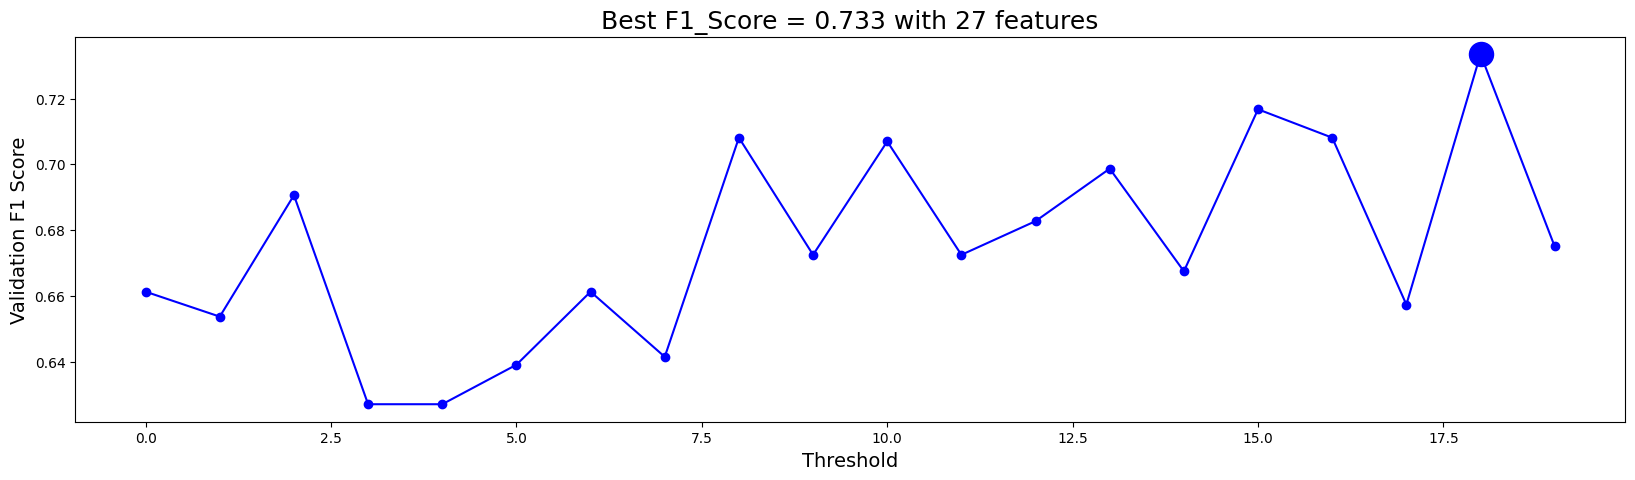

In [ ]:
# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(scores,'-o',color='blue')
plt.scatter([iter],[best_f1], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Best F1_Score = {best_f1:.3f} with {len(columns_on_with_best_score)} features',size=18)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, class_weight='balanced')
boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=2)
boruta_selector.fit(X_train.values,y_train.values)

In [ ]:
print('==============BORUTA=============')
np.array(X_train.columns[:-1])[boruta_selector.support_].tolist()

==============BORUTA=============


IndexError: ignored

In [ ]:
X_train.columns[boruta_selector.support_]

Index(['f2_by_id3_median', 'sum_f3_f6', 'subtraction_f1_f2', 'division_f1_f2',
       'division_f2_f1', 'division_f3_f5', 'division_f6_by_id3_sum_f4',
       'division_f7_f5', 'division_f7_f8', 'division_f7_f3_by_id3_sum',
       'division_f7_f5_by_id3_sum', 'division_f1_by_id3_sum_f2_by_id3_sum',
       'multiplication_f3_f6'],
      dtype='object')

In [ ]:
# Select the chosen features from our dataframe.
selected = list(X_train.columns[boruta_selector.support_])

In [ ]:
selected

['f2_by_id3_median',
 'sum_f3_f6',
 'subtraction_f1_f2',
 'division_f1_f2',
 'division_f2_f1',
 'division_f3_f5',
 'division_f6_by_id3_sum_f4',
 'division_f7_f5',
 'division_f7_f8',
 'division_f7_f3_by_id3_sum',
 'division_f7_f5_by_id3_sum',
 'division_f1_by_id3_sum_f2_by_id3_sum',
 'multiplication_f3_f6']

In [ ]:
X_test

In [ ]:
X_train[selected]

,f2_by_id3_median,sum_f3_f6,subtraction_f1_f2,division_f1_f2,division_f2_f1,division_f3_f5,division_f6_by_id3_sum_f4,division_f7_f5,division_f7_f8,division_f7_f3_by_id3_sum,division_f7_f5_by_id3_sum,division_f1_by_id3_sum_f2_by_id3_sum,multiplication_f3_f6
398,2.00,10.00,0,1.00,1.00,1.67,29.76,2.33,0.58,0.02,0.00,1.87,25.00
1243,1.00,8.67,0,1.00,1.00,0.67,1.39,0.43,0.50,0.45,0.10,1.00,18.67
367,2.00,9.55,0,1.00,1.00,0.00,0.02,0.00,0.41,0.03,0.00,1.05,22.76
117,3.50,10.00,0,1.00,1.00,5.00,4.38,22.00,0.96,2.26,1.29,1.00,25.00
1001,2.00,9.21,0,1.00,1.00,0.00,2.78,0.00,0.17,0.03,0.01,1.04,21.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1569,1.00,5.14,0,1.00,1.00,0.02,0.01,0.13,0.80,8.00,0.13,1.00,4.14
2304,14.00,8.45,0,1.00,1.00,0.07,0.17,0.49,0.71,1.96,0.14,1.07,17.55
505,3.00,9.21,1,1.04,0.96,0.01,0.10,0.05,0.84,0.16,0.00,1.09,21.18
2783,2.00,2.23,0,1.00,1.00,0.25,32.05,1.50,0.67,0.02,0.00,1.87,1.23


In [ ]:
y_test

910     0
309     1
2323    0
3003    0
1780    1
       ..
1012    0
1477    1
1381    0
1222    0
196     0
Name: label, Length: 625, dtype: int64

In [ ]:
clf = CatBoostClassifier(random_state=42)
# train_pool = Pool(X_train[selected], y_train, feature_names=selected)
# test_pool = Pool(X_test[current_feat], y_test, feature_names=current_feat)
clf.fit(X_train[selected],y_train,verbose=0)
y_pred = clf.predict_proba(X_test[selected])[:, 1]
y_pred_metki =  clf.predict(X_test[selected])
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_metki, average='macro')
roc = roc_auc_score(y_test, y_pred)
scores.append(f1)
print(len(current_feat),current_feat)
print("AUC_ROC----"+str(roc))
print("F1-score-----"+str(f1))
print("Precision-----"+str(precision))
print("Recall-----"+str(recall))

8 ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8']
AUC_ROC----0.7519762845849801
F1-score-----0.6664981604740641
Precision-----0.7463471525393892
Recall-----0.6474967061923583


#### Not Touch


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [ ]:
# N_SPLITS = 5

In [ ]:
# features_for_selection = list(X.columns[8::])
# current_feat = list(X.columns[:8])

In [ ]:
# cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=22)
# scores = []
# best_f1 = 0
# columns_with_best_score=current_feat
# scores = []
# all_iter_col = []
# count=1
# for i in range(n_feature):
#   print('_'*5+f'Iter_{i}'+'_'*5)
#   curr_f1=0
#   for feature in range(len(features_for_selection)):
#     iter_feat = current_feat
#     iter_feat.append(features_for_selection[feature])
#     cv_scores_AUC_ROC = np.empty(N_SPLITS)
#     cv_scores_f1_score = np.empty(N_SPLITS)
#     cv_scores_Precision = np.empty(N_SPLITS)
#     cv_scores_Recall = np.empty(N_SPLITS)

#     for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):

#       X_train_сv, X_val_сv = X_train.iloc[train_idx], X_train.iloc[test_idx]
#       y_train_сv, y_val_сv = y_train.iloc[train_idx], y_train.iloc[test_idx]

#       train_pool = Pool(X_train[current_feat], y_train, feature_names=current_feat)
#       test_pool = Pool(X_val_сv[current_feat], y_val_сv, feature_names=current_feat)

#       clf = CatBoostClassifier()
#       clf.fit(train_pool,
#               eval_set=test_pool,
#               verbose=0)

#       y_pred_metki = clf.predict(X_val_сv)
#       y_pred = clf.predict_proba(X_val_сv)[:, 1]
#       precision = precision_score(y_val_сv, y_pred_metki)
#       recall = recall_score(y_val_сv, y_pred_metki)
#       cv_scores_AUC_ROC[idx] = roc_auc_score(y_val_сv, y_pred)
#       cv_scores_f1_score[idx] = f1_score(y_val_сv, y_pred_metki,average='macro')
#       # print(precision)
#       cv_scores_Precision[idx] = precision
#       cv_scores_Recall[idx] = recall
#     if np.mean(cv_scores_f1_score)>curr_f1:
#       curr_f1 = np.mean(cv_scores_f1_score)
#       best_column = features_for_selection[feature]

#   features_for_selection.remove(best_column)
#   current_feat.append(best_column)
#   if curr_f1>best_f1:
#     best_f1 = curr_f1
#     columns_with_best_score = current_feat
#     print(columns_with_best_score)
#     iter = i
#     # iter_feat = current_feat

#   scores.append(best_f1)
#   # current_feat = columns_with_best_score
#   all_iter_col.append(current_feat)

#   print("AUC_ROC----"+str(np.mean(cv_scores_AUC_ROC)))
#   print("F1-score-----"+str(np.mean(cv_scores_f1_score)))
#   print("Precision-----"+str(np.mean(cv_scores_Precision)))
#   print("Recall-----"+str(np.mean(cv_scores_Recall)))


_____Iter_0_____


NameError: ignored